# Doc 12 - Densenet em cima do dataset de treinamento

Nessa documentação iremos realizar o treinamento da rede em cima do training set para verificiar se o problema que temos tido com o treinamento está relacionado a uma falta de conexão entre o train/val/test sets.

In [1]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns
import splitfolders
import cv2

# 1 - Visualização de dados

In [2]:
#Função para visualização
def plot_image_counts2(folder_path):
    #Contadores pra plotar
    counts = {'cancer_type': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue',  'red'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

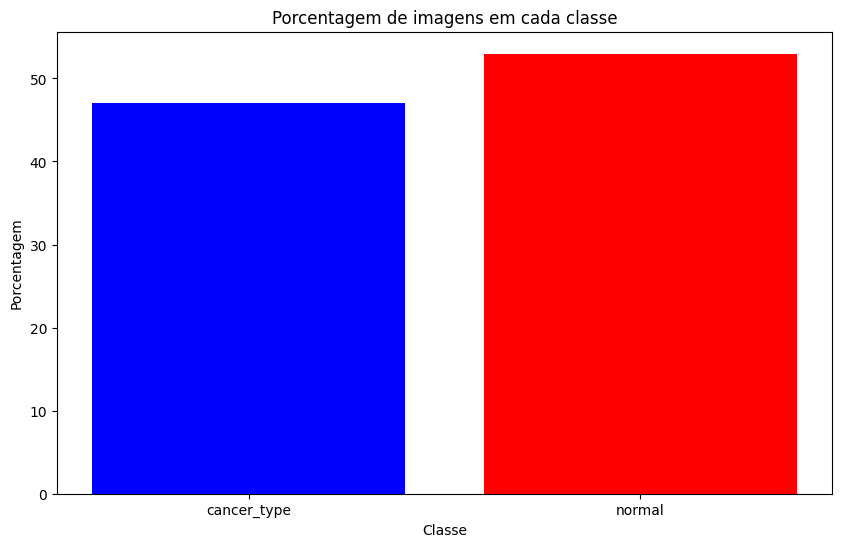

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type        3648     47.02849
normal             4109     52.97151


In [6]:
#Train set binário
folder_path = r'F:\Coisinhas\Coisas_UNB\TCC\binary_augmented\train'
plot_image_counts2(folder_path)

Precisamos agora tornar esse training set em um train/val/test sets. Eu coloquei todas as imagens de cada classe em um só folder (dataset) manualmente para utilizar a biblioteca splitfolders para isso.

# 2 - Separação do dataset

In [9]:
#Usado para separar em training, validation e test sets

input_folder = 'dataset' 
output_folder = 'final_dataset' 

splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.7, .15, .15), group_prefix=None)

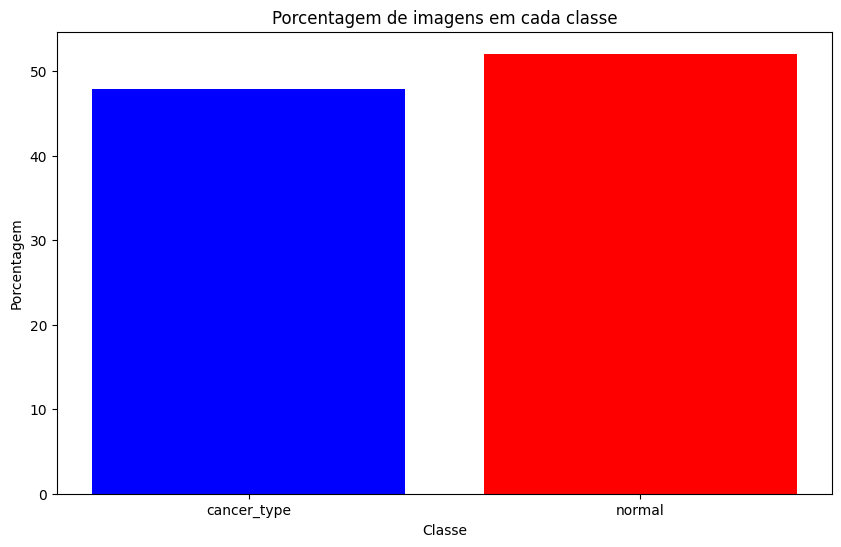

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type        2970    47.934151
normal             3226    52.065849


In [10]:
#Novo train set binário
folder_path = r'F:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 12 - Densenet em cima do dataset de treinamento\final_dataset\train'
plot_image_counts2(folder_path)

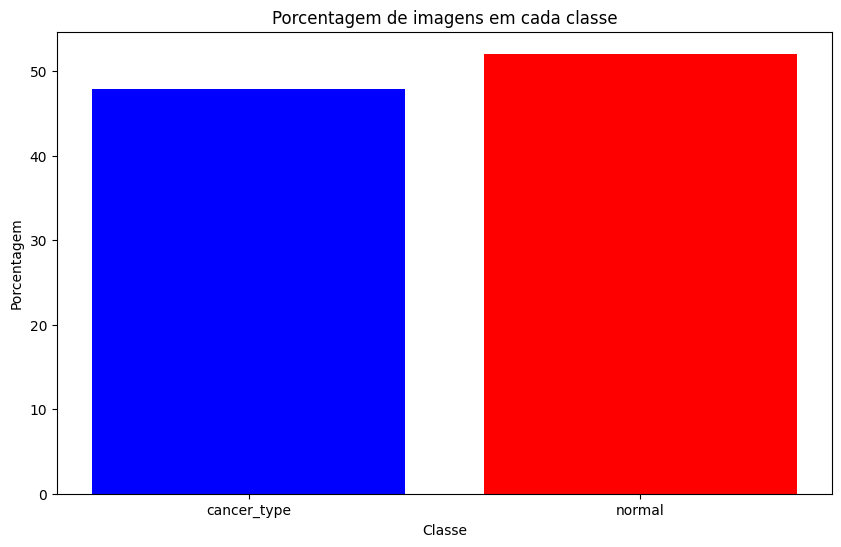

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         636    47.927656
normal              691    52.072344


In [11]:
#Novo val set binário
folder_path = r'F:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 12 - Densenet em cima do dataset de treinamento\final_dataset\val'
plot_image_counts2(folder_path)

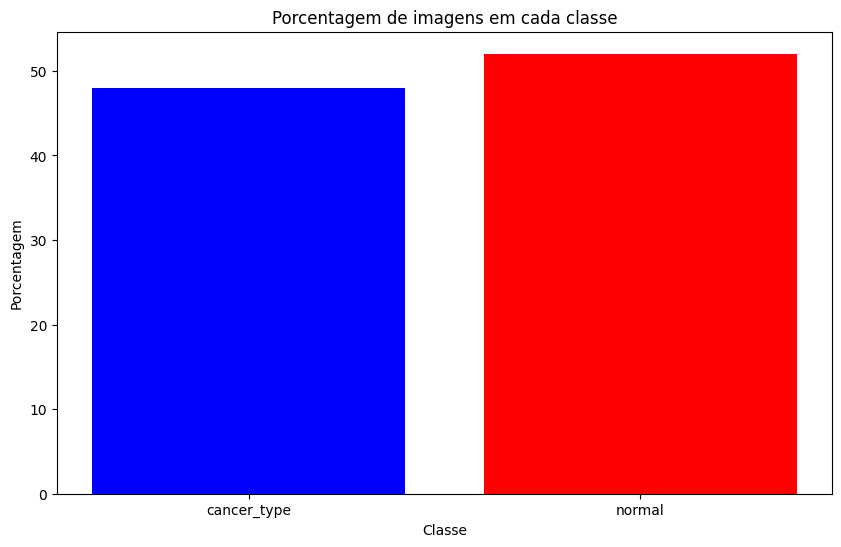

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         638    47.969925
normal              692    52.030075


In [12]:
#Novo test set binário
folder_path = r'F:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 12 - Densenet em cima do dataset de treinamento\final_dataset\test'
plot_image_counts2(folder_path)

Tinhamos pensado que, por conta de como as imagens foram obitadas, tinhamos apenas 1 canal sendo usado, mas a conversao para png fez com que as imagens tivessem tres canais repetidos.

In [40]:
image = cv2.imread(r'F:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 12 - Densenet em cima do dataset de treinamento\final_dataset\test\cancer_type\DBT-P00023_rmlo.png')
image.shape

(614, 472, 3)

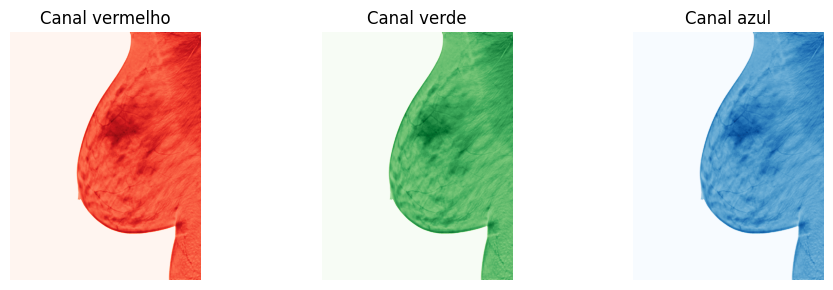

In [41]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

R, G, B = cv2.split(image)

plt.figure(figsize=(10, 3))

plt.subplot(1, 3, 1)
plt.imshow(R, cmap='Reds')
plt.title('Canal vermelho')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(G, cmap='Greens')
plt.title('Canal verde')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(B, cmap='Blues')
plt.title('Canal azul')
plt.axis('off')

plt.tight_layout()
plt.show()

# 3 - Transfer learning com densenet

In [2]:
#Diretórios
train_dir = r'F:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 12 - Densenet em cima do dataset de treinamento\final_dataset\train'
val_dir = r'F:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 12 - Densenet em cima do dataset de treinamento\final_dataset\val'
test_dir = r'F:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 12 - Densenet em cima do dataset de treinamento\final_dataset\test'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 32

#CLasses
num_classes = 2

In [3]:
#Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 6196 images belonging to 2 classes.
Found 1327 images belonging to 2 classes.
Found 1330 images belonging to 2 classes.


In [4]:
#Transfer learning com a densenet - flatten
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose = 1, restore_best_weights=True)

In [7]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 2228s 11s/step - accuracy: 0.6230 - loss: 8.4262 - val_accuracy: 0.6858 - val_loss: 1.1226
Epoch 2/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 2225s 11s/step - accuracy: 0.7473 - loss: 0.7350 - val_accuracy: 0.6843 - val_loss: 1.1791
Epoch 3/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 2285s 12s/step - accuracy: 0.7844 - loss: 0.4943 - val_accuracy: 0.6843 - val_loss: 1.9198
Epoch 4/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 2254s 12s/step - accuracy: 0.8707 - loss: 0.3303 - val_accuracy: 0.7129 - val_loss: 0.7151
Epoch 5/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 2255s 12s/step - accuracy: 0.8555 - loss: 0.3171 - val_accuracy: 0.6323 - val_loss: 0.8299
Epoch 6/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 2267s 12s/step - accuracy: 0.8858 - loss: 0.2699 - val_accuracy: 0.6956 - val_loss: 0.7035
Epoch 7/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 2262s 12s/step - accuracy: 0.9442 - loss: 0.1558 - val_accuracy: 0.6518 - val_loss: 0.9643
Epoch 8/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 2260s 12s/step - accuracy: 0.9258 - loss: 0.185

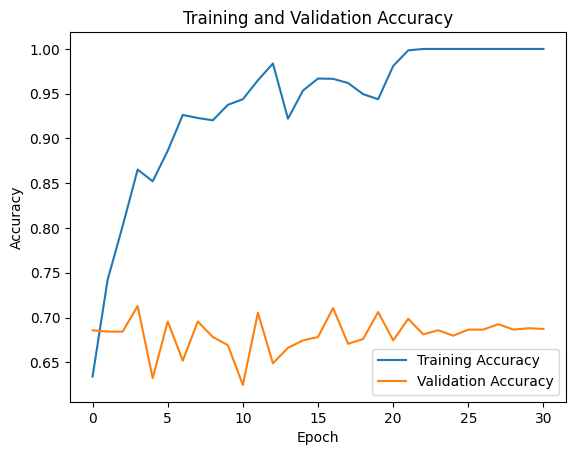

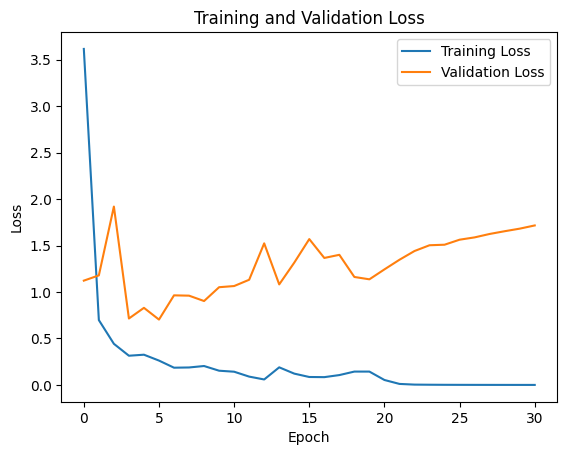

In [8]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

42/42 ━━━━━━━━━━━━━━━━━━━━ 371s 9s/step - accuracy: 0.7045 - loss: 0.7072
Test Accuracy: 68.95%
Test Loss: 0.7561


In [10]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

42/42 ━━━━━━━━━━━━━━━━━━━━ 379s 9s/step


array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [11]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, ..., 1, 1, 1])

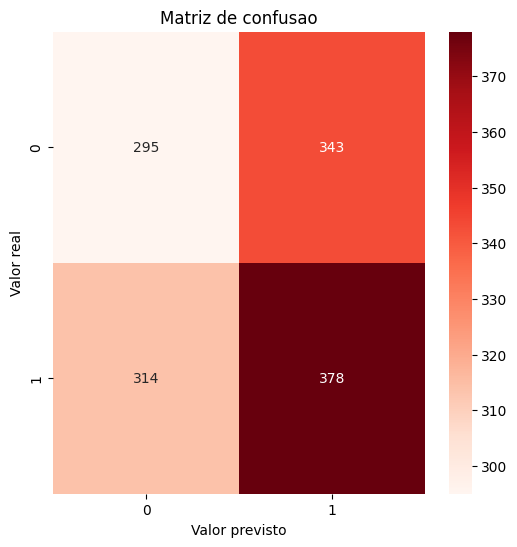

In [12]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

Podemos ver que mesmo dentro apenas do training set a rede ainda não foi capaz de efetivamente aprender as características das imagens.